### Generating the dataset

In [1]:
using PyPlot

In [2]:
srand(1)

# number of users
d1 = 190;

# number of items
d2 = 210;

# number of queries
n = 6000;

In [3]:
# generate the hidden ratings
ThetaS = rand(d1,4) * rand(4,d2)

# Need to have the sum of rows equaling 0
for i = 1:d1
    ThetaS[i,:] -= mean(ThetaS[i,:])
end

# Need to make the Frobenius norm <= 1
ThetaS = ThetaS / vecnorm(ThetaS);

In [4]:
y = []
X = []

for i = 1:n
    Xi = zeros(d1, d2)
    
    lin = rand(1:d1)
    c1 = rand(1:d2)
    c2 = rand(1:d2)
    while c2 == c1
        c2 = rand(1:d2)
    end
    
    Xi[lin,c1] = 1
    Xi[lin,c2] = -1
    Xi = Xi * sqrt(d1 * d2)
    
    push!(X, Xi)
    
    if ThetaS[lin,c1] > ThetaS[lin,c2]
        push!(y, 1)
    else
        push!(y, 0)
    end
end

### Helper functions

In [5]:
function nucNorm(A)
    return sum(svd(A)[2])
end

nucNorm (generic function with 1 method)

In [6]:
# make sure the matrix's rows are centered

function adjust(X)
    ans = copy(X)
    
    for i = 1:size(X)[1]
        ans[i,:] -= mean(ans[i,:])
    end
    
    return ans
end

adjust (generic function with 1 method)

In [7]:
# The objective function

function obj(Theta, ns)
    ans = 0
    
    for i = 1:ns
        ans = ans + log(1 + e^(trace(Theta' * X[i]))) - y[i] * trace(Theta' * X[i])
    end
    
    return ans / ns
end

obj (generic function with 1 method)

In [8]:
# Compute the derivative of the objective loss
# Theta is our current guess
# numSamples represents the number of X's we are considering

function deltaF(Theta, ns)
    
    ans = zeros(d1,d2)
    
    for i = 1:ns
        t = e^trace(Theta' * X[i])
        ans = ans + (t / (1 + t) - y[i]) * X[i]
    end
    
    return ans / ns
    
end

deltaF (generic function with 1 method)

In [9]:
# The proximal function
# return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# equivalent to (lamda*lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

function prox(lambda, V)
    
    A,S,B = svd(V)
    S = max(S - lambda, 0)
    
    return adjust(A * diagm(S) * B')
    
end

prox (generic function with 1 method)

In [10]:
function checkKKT(lamb, Theta, ns)
    println("Checking KKT conditions")
    
    tot = 0
    
    for i = 1:ns
        tot = tot + (e ^ trace(Theta' * X[i]) / (1 + e ^ trace(Theta' * X[i])) - y[i]) * X[i]
    end
    
    tot = tot / ns
    
    U,S,V = svd(Theta)
    k = rank(Theta)
    U = U[:,1:k]
    V = V[:,1:k]
    
    tot = tot + lamb * U * V'
    
    if norm(tot) <= lambda
        println("GOOD - the norm is smaller than lambda")
    else
        println("OOPS - the norm is greater than lambda")
    end
    
    println(norm(U' * tot))
    
    println(norm(tot * V))
    
end

checkKKT (generic function with 1 method)

##### As a sanity check, make sure that our gradient steps indeed decreases obj loss

In [11]:
Theta = adjust(rand(d1,d2))

println("Hidden loss ", obj(ThetaS, n))
println("Current loss ", obj(Theta, n))

for stp = 1:5
    alpha = 1.0

    newTheta = Theta - alpha * deltaF(Theta, n)
    newTheta = adjust(newTheta)

    println("Loss after ", stp, " steps: ", obj(newTheta, n))
    
    Theta = copy(newTheta)
end

Hidden loss 0.33953828241367656
Current loss 33.52888351973209
Loss after 1 steps: 26.581566144922824
Loss after 2 steps: 20.740166384947962
Loss after 3 steps: 15.91524159581662
Loss after 4 steps: 11.989627851306716
Loss after 5 steps: 8.842892554875345


#### We'll pick a specific number of samples in terms of n

In [12]:
numSamples = []
for den = [3,2,1.5,1.33,1.16,1]
    push!(numSamples, convert(Int64, floor(n / den)))
end

#### Let's test out the algorithm

In [13]:
curTheta = zeros(d1,d2) 
lambda = 0.1   # the regularization parameter
lambda_k = .05   # the step size

overallLF = []

for ns = numSamples
    LF = []
    
    println("working with ", ns, " samples")
    
    maxit = 200
    @time for steps = 1:maxit
        # retain the old loss
        oldLoss = vecnorm(ThetaS - curTheta)^2
        
        # first, go in the direction of f
        V = curTheta - lambda_k * deltaF(curTheta, ns)
        
#         println(maximum(V), " ", minimum(V))
#         if steps > 350
#             println(V)
#         end
        
        # now, perform the proximal step
        newTheta = prox(lambda * lambda_k, V)

        # some information about runs
        if steps % 25 == 0 || steps == maxit
            println("at iteration ", steps)
            
            if steps == maxit
                println("f + g = ", obj(curTheta, ns) + lambda * nucNorm(curTheta))
                println("f = ", obj(curTheta, ns))
                println("g = ", lambda * nucNorm(curTheta))
                println("Loss = ", vecnorm(ThetaS - newTheta)^2)
                println()
                checkKKT(lambda, newTheta, ns)
                println()
            end
        end

        # update the loss array
        push!(LF, vecnorm(ThetaS - newTheta)^2)
        
        # check if the loss is not decreasing anymore
        newLoss = vecnorm(ThetaS - newTheta)^2
#         if abs(oldLoss - newLoss) < 1e-7
#         if newLoss < 0.4
#             push!(overallLF, vecnorm(ThetaS - newTheta)^2)
            
#             println("Converged after ", steps, " iterations")
#             checkKKT(lambda, newTheta, ns)
#             println()
            
#             break
#         end
        
        # if I hit the max number of steps, stop anyway
        if steps == maxit
            push!(overallLF, vecnorm(ThetaS - newTheta)^2)
        end
        
        # update Theta for the next iteration
        curTheta = copy(newTheta)
    end
    
    dims = convert(Int64, (d1+d2)/2)
    filename = string("./data/", dims, "-", ns, ".txt")
    writedlm(filename, LF)
    
    println()
    println()
end

working with 2000 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteration 150
at iteration 175
at iteration 200
f + g = 0.3599593161503586
f = 0.13859918383959072
g = 0.22136013231076787
Loss = 0.6302220578409478

Checking KKT conditions
GOOD - the norm is smaller than lambda
0.026006643063403678
0.026081067265269528

335.078655 seconds (6.62 M allocations: 375.950 GB, 11.76% gc time)


working with 3000 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteration 150
at iteration 175
at iteration 200
f + g = 0.3923828347903726
f = 0.1682680850144779
g = 0.22411474977589468
Loss = 0.41860726100589996

Checking KKT conditions
GOOD - the norm is smaller than lambda
0.01856922766887109
0.018597279727144592

498.430389 seconds (9.66 M allocations: 563.232 GB, 11.39% gc time)


working with 4000 samples
at iteration 25
at iteration 50
at iteration 75
at iteration 100
at iteration 125
at iteration 150
at

In [14]:
writedlm(string("./data/", convert(Int64, (d1+d2)/2), "-final.txt"), overallLF)

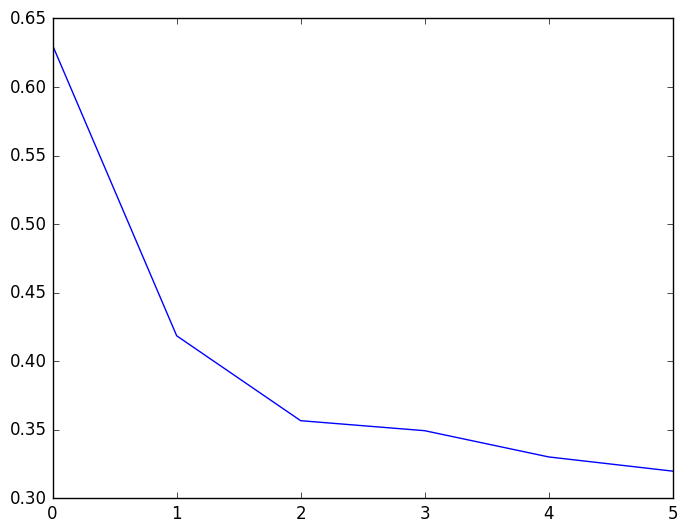

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3444a3fd0>

In [15]:
# plotting the loss function
plot(overallLF)

In [16]:
# newLF = []
# for i = 1:length(LF)
#     push!(newLF, log(LF[i]))
# end

# plot(newLF)

In [17]:
# writedlm("./data/t.txt", LF)

In [18]:
overallLF

6-element Array{Any,1}:
 0.630222
 0.418607
 0.356691
 0.349405
 0.330272
 0.319915